GRANAD at a glance

# Static quantities

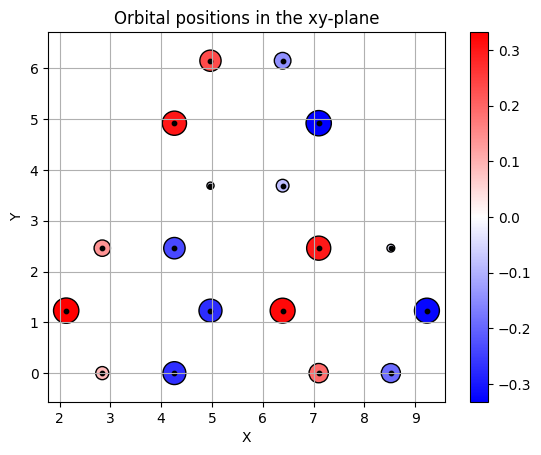

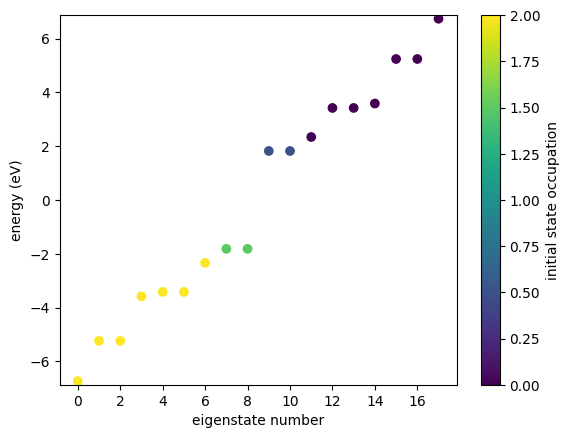

pz hopping between 0th and 2nd site 0j
0-th site occupation in SITE basis (0.05555555555555561+0j)
homo occupation in ENERGY basis (0.08333333333333326+0j)


HOMO-LUMO x-dipole (-1.0318472612379848+0j)


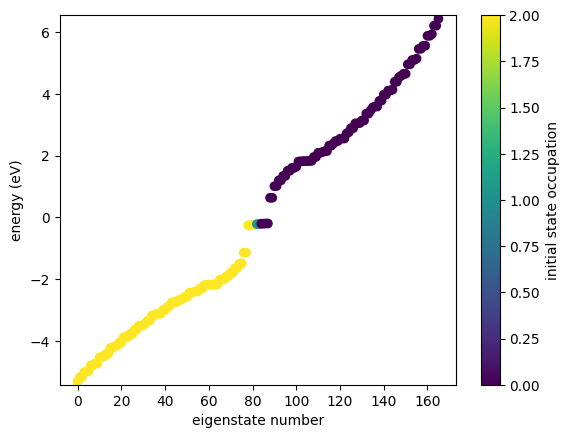

In [1]:
from granad import *
graphene = MaterialCatalog.get("graphene") # MaterialCatalog.available() lists all materials

flake = graphene.cut_flake(Triangle(10, armchair = True)) # more shapes available or define arbitrary polygons
flake.show_2d( display = flake.eigenvectors[:, flake.homo] ) # display "fermi level state"
flake.set_excitation(from_state = flake.homo, to_state = flake.lumo + 1, excited_electrons = 1) # excitations
flake.show_energies() # energies

# examples of physical quantities
print("pz hopping between 0th and 2nd site", flake.hamiltonian[0,2])
print("0-th site occupation in SITE basis", flake.initial_density_matrix.diagonal()[0])
print("homo occupation in ENERGY basis", flake.initial_density_matrix_e.diagonal()[flake.homo])
print("HOMO-LUMO x-dipole", flake.dipole_operator_e[0, flake.homo, flake.lumo])

# customization
onsite, nn, nnn = [0, -2., 0.1]
new_hoppings = [onsite, nn, nnn]
custom_graphene = MaterialCatalog.get("graphene", hoppings = new_hoppings) # pass your own hoppings
flake = custom_graphene.cut_flake(Triangle(30))
flake.show_energies() # energies

# Dynamic Quantities

RHS compiled
RHS compiled


24.983461962513783 %


49.98897464167585 %


74.99448732083793 %


100.0 %


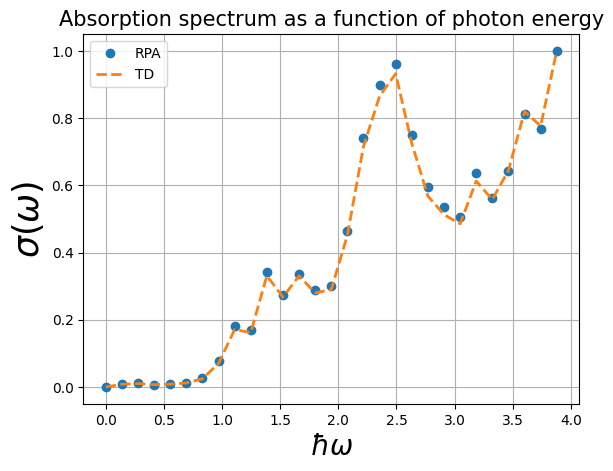

In [2]:
# TD sims

# pulsed field
pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2)

# time evolution
result = flake.master_equation(
    expectation_values = [ flake.dipole_operator ],  # compute expectation values of physical quantities
    end_time=40,
    relaxation_rate=1/10,
    illumination=pulse,
)
omega_max = 4
omega_min = 0
p_omega = result.ft_output( omega_max, omega_min )[0]
omegas_td, pulse_omega = result.ft_illumination( omega_max, omega_min )
absorption_td = jnp.abs( -omegas_td * jnp.imag( p_omega[:,0] / pulse_omega[:,0] ) )

# RPA
omegas_rpa = omegas_td
polarizability = flake.get_polarizability_rpa(
    omegas_rpa,
    relaxation_rate = 1/10,
    polarization = 0, 
    hungry = 2 )
absorption_rpa = jnp.abs( polarizability.imag * 4 * jnp.pi * omegas_rpa )

import matplotlib.pyplot as plt
plt.plot(omegas_rpa, absorption_rpa / jnp.max(absorption_rpa), 'o', linewidth=2, label = 'RPA')
plt.plot(omegas_td, absorption_td / jnp.max(absorption_td), linewidth=2, ls = '--', label = 'TD' ) 
plt.xlabel(r'$\hbar\omega$', fontsize=20)
plt.ylabel(r'$\sigma(\omega)$', fontsize=25)
plt.title('Absorption spectrum as a function of photon energy', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

# Miscellenia

All tutorials as [jupyter files](https://github.com/GRANADlauncher/granad/tree/gh-pages/tutorials).